Element pattern
====
Last updated: 10 Oct 2018  

Element pattern: This notebook will perform several operations related to the element pattern.  
1) Read an exported antenna pattern file from CST and save in a pickle format data file for use by other notebooks. The units for the array are the same as what CST exports.  
2) Calculate a pattern for a circular patch based on a cavity model.  Model calculates the electric field which is converted to intensity $W/m^2$ before saving a pickle format data file.
3) Calculate a proxy pattern using the function defined below.  The values in the array don't have any units associated with them.  The values are normalized with a maximum value equal to 1.  The array is saved to a pickle format data file 

The element pattern data can then be loaded in to the 'array pattern.ipynb' or the 'antenna temperature.ipynb' notebooks, where the pattern data is multiplied by the array factor.  

Reference:  
1) Microstrip Antenna Design Handbook, by Ramesh Garg, Prakash Bhartia, Inder Bahl, and Apisak Ittipihoon, Artech House,2001, ISBN 0-89006-513-6.  See page 324 for radiation fields of a circular patch.  
2) Antenna gain, https://en.wikipedia.org/w/index.php?title=Antenna_gain&oldid=858383992 (last visited Oct. 9, 2018).
3) Isotropic radiator, https://en.wikipedia.org/w/index.php?title=Isotropic_radiator&oldid=858869900 (last visited Oct. 10, 2018).

In [1]:
import os
import pickle
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

# Read CST antenna pattern file
For now this is a junk file exported from CST.  The file is from a conformal array of elements.  
Need to pay attenstion to the orientation of theta and phi.  
header from data file:  
```
// CST Farfield Source File
// Version: 3.0 
// Data Type Farfield 
// #Frequencies 1 
// Position 2.255973e-017 0.000000e+000 -8.354133e-002 
// zAxis 0.000000e+000 1.000000e+000 0.000000e+000 
// xAxis 0.000000e+000 0.000000e+000 1.000000e+000 
// Radiated/Accepted/Stimulated Power , Frequency 1.905259e+000 1.981235e+000 2.000000e+000 2.240000e+009 
// >> Total #phi samples, total #theta samples 361 181
// >> Phi, Theta, Re(E_Theta), Im(E_Theta), Re(E_Phi), Im(E_Phi): 
```

In [0]:
# read the pattern data from the CTS file
A = np.loadtxt('Antenn Pattern from CST.ffs')
print('length of data set = {:d} lines'.format(len(A)))

In [0]:
# create arrays to hold the pattern data
step = 1
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max+1,step)

E_theta = np.empty((len(theta),len(phi)), dtype=complex)
E_phi = np.empty((len(theta),len(phi)), dtype=complex)

# digest the data
for k in range(len(A)):
    i = int(A[k,1])  # theta index
    j = int(A[k,0])  # phi index
    E_theta[i,j] = A[k,2] + A[k,3]*1J
    E_phi[i,j] = A[k,4] + A[k,5]*1J

In [0]:
# export element pattern
R = np.sqrt(E_theta**2+E_phi**2)
pickle.dump(R, open( "EP.pkl", "wb" ))

In [0]:
# Plot the pattern
F = np.sqrt(E_theta**2+E_phi**2)
F_plt = 20*np.log10(abs(F)) # convert to dB magnitude for plotting
F_plt  = np.clip(F_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max+1,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,F_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [0]:
# plotting principle plane cuts
plt.plot(theta,F_plt[:,0],'b',label='phi=0')
plt.plot(theta,F_plt[:,45],'r',label='phi=45')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-10,30)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.show()

In [0]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -10 #set plot grid
maxGrid = 30
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,F_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,F_plt[:,45],'r',linewidth = 2,label='phi=45')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

# Radiation pattern for a circular disk
This section of the notebook will also calculate the pattern for a circular disk element using equations from reference [1].  Equations 5.19 and 5.20 are used to model a circular disk antenna.  Section 5.2.1 describes a cavity model for the circular element.  Radiation fields are developed from the model.  Assuming a mode corresponding to n = m = 1, the minimum radius and resonance frequency is calculated.  

The far field values obtained from equations 5.19 and 5.20 seem adquate for the initial analysis.  Actual radiation patterns will be used when they are available.

See equation 5.17 for V  

$V=hE_nJ_n(X_{nm})$  

V is known as the edge voltage at phi = 0.  
En = electric field for n  
Jn is the Bessel function of order n.  

The far fields are delineated by the condition that:  
$r >> r'$  or $r \geq \frac {2L^2}{\lambda _0}$  
where L is the largest dimension of the aperature.  

In [13]:
# find wave length for the L-Band element
f = 1435*1e6 # Hz
c = 299792458 # speed of light m/s
L = c/(f) # wave length

# paramters used in the model
a = (L/4)/2 # disk metalization radius 1/4 Lambda dia patch
ko = 1 # free space wave number
eo = 8.85e-12 # free space dielectric constant
er = 1 # air
h = 0.00635 # 0.25 in
V = 1 # edge voltage
LL = 0.0254  # 4 in
r = 1 # distance to observation point, m
n = 1 # order for Bessel function

The E-plane radiation fields should be multiplied by $F_3(\theta)$ and the H-plane data fields should by $F_4(\theta)$ per disscussion in section 4.3 of reference [1].  The above expressions for radiation fields assume that the radiating slots are in free spce.  The effects of theground plane and substraite of the antenna on the radiation pattern can be included by means of factors $F_3(\theta)$ and $F_4(\theta)$, equations 4.41 and 4.42 in reference [1].  Also see 2.59 in Chapter 2 of reference [1].  

In [14]:
step = 1
theta_min = -90
theta_max = 90
phi_min = 0
phi_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevents divide by zero
theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
phi = np.arange(phi_min,phi_max,step,dtype=float)*np.pi/180

E_theta = np.zeros((len(theta),len(phi)),dtype=complex)
E_phi = np.zeros((len(theta),len(phi)),dtype=complex)

for i in range(len(theta)):
    for j in range(len(phi)):
        F3n = 2*np.cos(theta[i])*np.sqrt(er-np.sin(theta[i])**2) # F3 numerator
        F3d = np.sqrt(er-np.sin(theta[i])**2) - 1j*er*np.cos(theta[i])*np.arctan(ko*h*np.sqrt(er-np.sin(theta[i])**2)) # F3 denominator
        F3 = (F3n/F3d) # eq 4.41
        E_theta [i,j] = ((-1j**n)*V*a*ko/2)*(np.exp(-1j*ko*r)/r)*np.cos(n*phi[j])*special.jvp(1,ko*a*np.sin(theta[i]))*F3 # eq 5.19

        F4n = 2*np.cos(theta[i]) # F4 numberator
        F4d = np.cos(theta[i]) - 1j*np.sqrt(er-np.sin(theta[i])**2)*np.arctan(ko*h*np.sqrt(er-np.sin(theta[i])**2)) # F4 denominator
        F4 = (F4n/F4d) # eq 4.42
        p1 = (n*(1j**n))*(V*a*ko/2)*(np.exp(-1j*ko*r)/r)
        p2 = np.sin(n*phi[j])*(special.jv(1,ko*a*np.sin(theta[i]))/(ko*a*np.sin(theta[i])))*np.cos(theta[i])
        E_phi[i,j] = p1*p2*F4 # eq 5.20

In [15]:
E_theta.min()

(-0.01094198497199769-0.007124295841189788j)

In [12]:
E_theta.max()

(0.01094198497199769+0.007124295841189788j)

In [9]:
# convert electric field to intensity
Zo = 120*np.pi
U = (1/Zo)*(E_theta**2+E_phi**2)

## save to data file

In [0]:
# export element pattern
pickle.dump(U, open( "EP.pkl", "wb" ))

## Plot element intensity

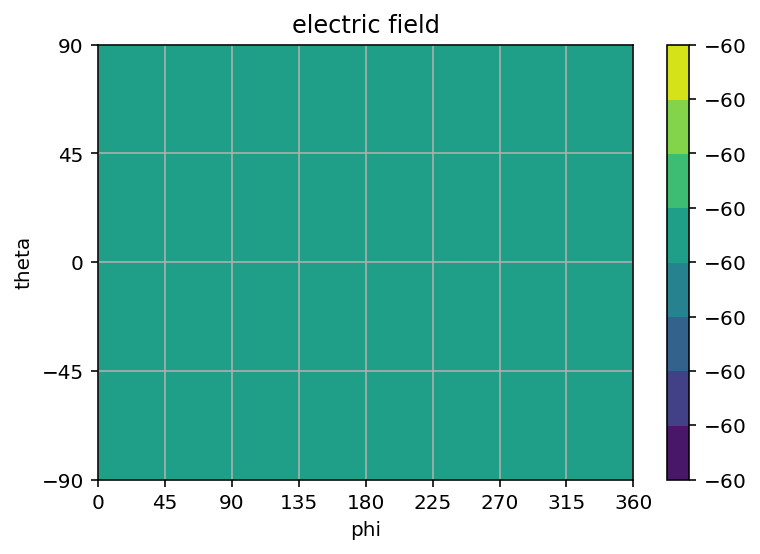

In [6]:
# plot the data
U_plt = 20*np.log10(abs(U)) # convert to dB magnitude for plotting
U_plt  = np.clip(U_plt,-60,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,U_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.title('electric field')
plt.show()

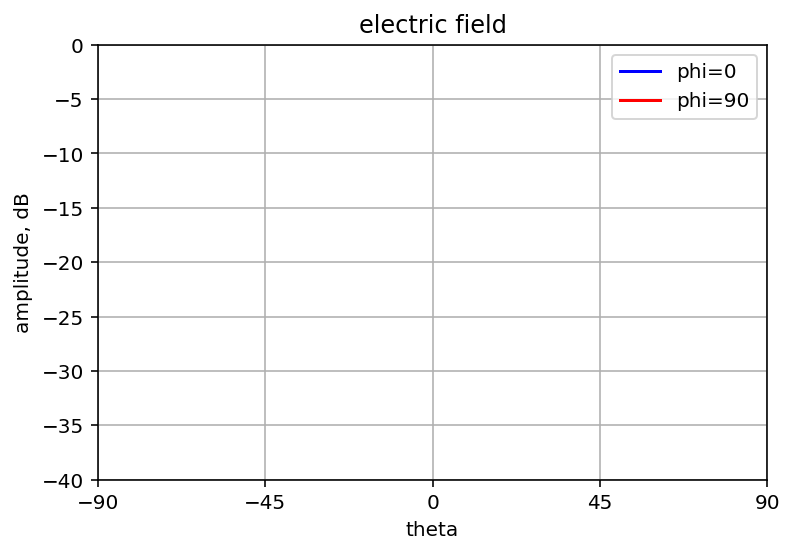

In [7]:
# plotting principle plane cuts
plt.plot(theta,U_plt[:,0],'b',label='phi=0')
plt.plot(theta,U_plt[:,int(90/step)],'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-40,0)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.title('electric field')
plt.show()

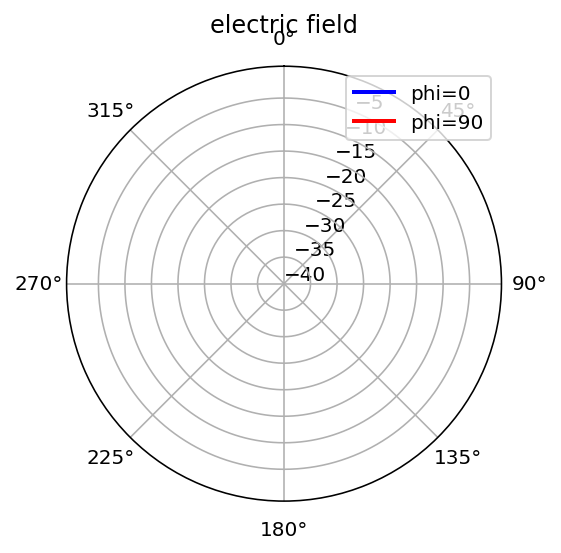

In [8]:
# plot data in polar format
theta_min = -90
theta_max = 90
theta = np.arange(theta_min,theta_max+1,step) # include end points
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 0
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,U_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,U_plt[:,45],'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("electric field")
plt.legend()
plt.show()

# Directivity
See page 101 of Antenna book.  

$D=\frac {4\pi}{\int _{0}^{{2\pi }}\int _{0}^{\pi} \vert \frac {E(\theta,\phi)}{E_{max}} \vert^2 \sin(\theta )\,d\theta \,d\phi}$

In [7]:
U_max = np.abs(U).max()

# limits of integration
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz((np.abs(U[:,i]/E_max)**2)*np.sin(theta),theta)

# then an integral over the result
D = 4*np.pi/np.trapz(I,phi)

print('directivity = {:f} dB'.format(10*np.log10(D)))

directivity = 1.773254 dB


# Directivity
See page 101 of Antenna book.  

$D=\frac {4\pi}{\int _{0}^{{2\pi }}\int _{0}^{\pi} \frac {U(\theta,\phi)}{U_{max}} \sin(\theta )\,d\theta \,d\phi}$

In [5]:
U_max = np.abs(U).max()

# limits of integration
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[:,i]/U_max)*np.sin(theta),theta)

# then an integral over the result
D = 4*np.pi/np.trapz(I,phi)

print('directivity = {:f} dB'.format(10*np.log10(D)))

directivity = 1.773254 dB


# Total radiated power
The total radiated power can be found by integrating over all directions:  

$P_{tot}=\int _{0}^{{2\pi }}\int _{0}^{\pi}U(\theta ,\phi )\sin(\theta )\,d\theta \,d\phi$

In [0]:
# limits of integration
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[:,i])*np.sin(theta),theta)

# then an integral over the result
P_tot = np.trapz(I,phi)

print('radiated power = {:f} dB'.format(10*np.log10(P_tot)))

# Directivity
$D=4\pi \left({\frac {U_{{{\mathrm  {max}}}}}{P_{{{\mathrm  {rad}}}}}}\right)$

In [0]:
U_max = np.abs(U.max())
print('U_max = {:.1f} dB'.format(10*np.log10(U_max)))
D = 4*np.pi*(U_max/P_rad)
print('directivity = {:f} dB'.format(10*np.log10(D)))

# Gain
Since the antenna is specified as being lossless the radiation efficiency is 1. The maximum gain is then equal to:  

$G=A_{eff}\,D$  

$G_{dBi}=10\log _{{10}}(G)$  

In [0]:
A_eff = 1  # antenna efficiency
G = A_eff*D
print('G = {:f}'.format(G))
print('G = {:.2f} dBi'.format(10*np.log10(G)))

# Proxy antenna pattern
The code below will generate an array of values that somewhat approximates the pattern from a single microstrip patch.  The following formula is used:  

$f(n) =
\begin{cases}
sin^2 \phi,  & \text{for 0 < $\phi$ < 180} \\
\frac {sin 4\phi}{20}, & \text{for 180 $\leq$ $\phi$ < 360}
\end{cases}$

The main lobe and back lobes are included.  

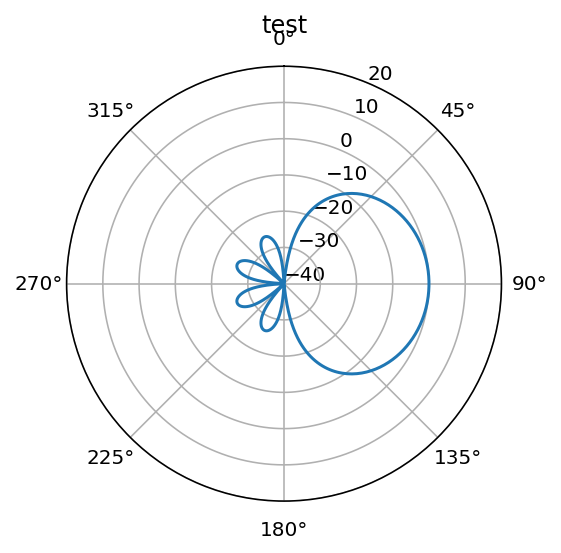

In [8]:
# define function over the following theta range
step = 1
phi_min = 0
phi_max = 360

phi = np.arange(phi_min,phi_max,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
phi = phi*np.pi/180 # convert to radians
X = np.zeros(len(phi),dtype=float)

# for 0 < theta < 180  
X[0:179] = np.sin(phi[0:179])**2

# for 180 < theta < 360  
X[180:-1] = np.sin(4*phi[180:-1])/20

X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# Polar plot
ax.plot(phi,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

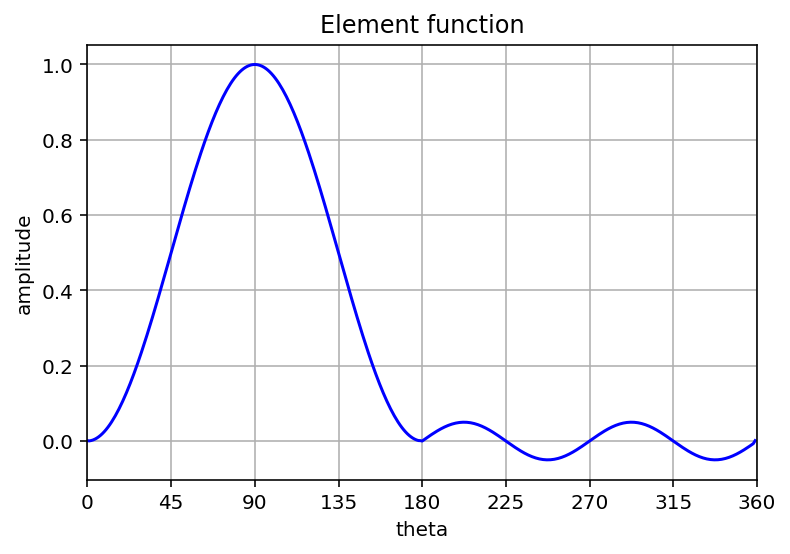

In [9]:
# plot function

phi = np.arange(phi_min,phi_max,step,dtype=float) # include end points
#X_plt = X
#U_plt = 20*np.log10(U_theta) # convert to dB magnitude for plotting
#U_plt  = np.clip(U_plt,-100,np.inf) # set limits for plotted data

plt.plot(phi,X,'b')

plt.grid(True)
#plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude')
#plt.ylim(-60,20)
# set plot limits
#theta_min = -50
#theta_max = 50
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.title('Element function')
plt.show()

## Create intensity pattern
Create the intensity array from the element function.

In [11]:
# define the range for theta
theta_min = 0
theta_max = 180
theta = np.arange(theta_min,theta_max+1,step)

# build full element pattern from function
U = (np.broadcast_to(X, (len(theta),len(X)))).T  # make radiation intensity array
print('array, number of rows = {:d}'.format(np.shape(U)[0]))
print('array, number of columns = {:d}'.format(np.shape(U)[1]))

array, number of rows = 360
array, number of columns = 181


## save to data file

In [53]:
# export element pattern as a complex array
pickle.dump(U.astype(dtype=complex), open( "EP.pkl", "wb" ))

## Contour plot
Change theta for plotting  

In [18]:
U.shape

(360, 181)

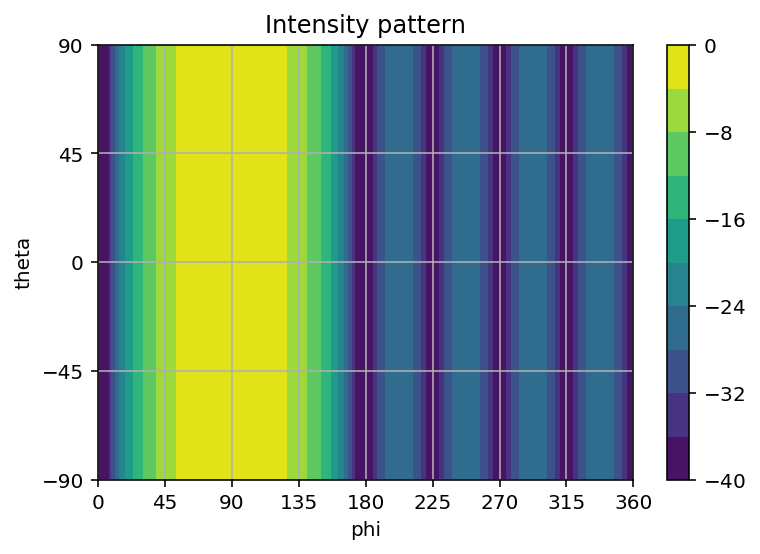

In [19]:
step = 1  # step size for various ranges
theta_min = -90
theta_max = 90
phi_min = 0
phi_max = 360

U_plt = 20*np.log10(np.abs(U)) # convert to dB magnitude for plotting
U_plt  = np.clip(U_plt,-40,np.inf) # set limits for plotted data

theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(theta, phi)

plt.contourf(Y1,X1,U_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.title('Intensity pattern')
plt.show()

## principle plane cuts

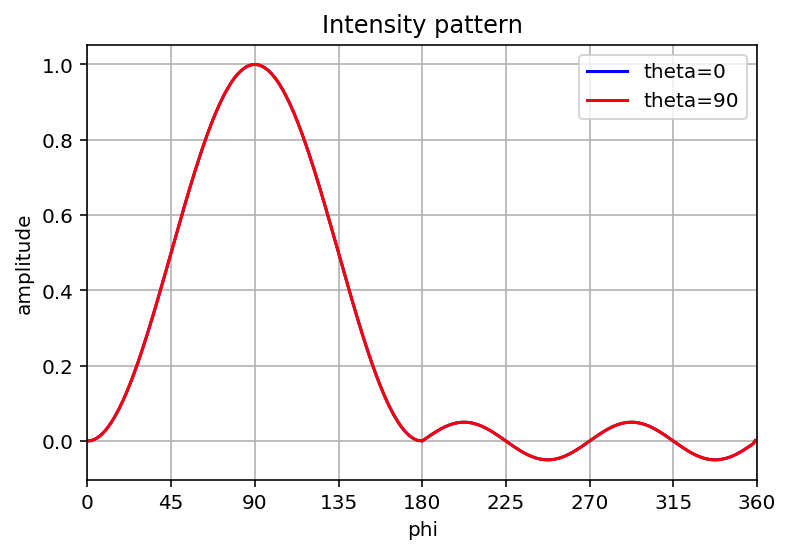

In [28]:
# plotting principle plane cuts
plt.plot(phi,U[:,0],'b',label='theta=0')
plt.plot(phi,U[:,int(90/step)],'r',label='theta=90')
plt.grid(True)
plt.legend()
plt.xlabel('phi')
plt.ylabel('amplitude')
#plt.ylim(40,100)
# set plot limits
#theta_min = -50
#theta_max = 50
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.title('Intensity pattern')
plt.show()

## Polar plot

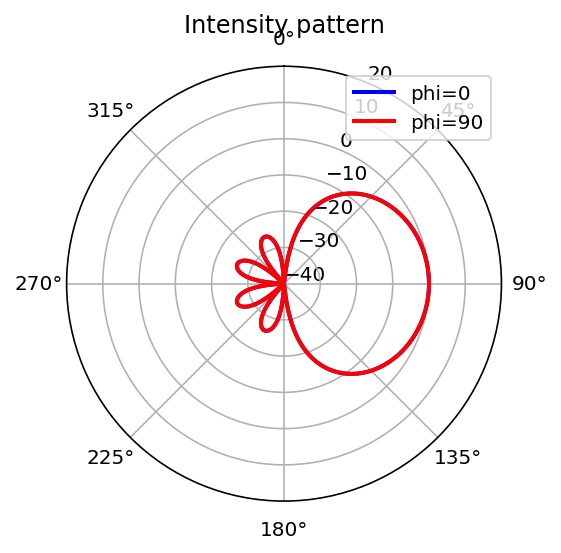

In [32]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta_min = -90
theta_max = 90
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# Polar plot
ax.plot(phi,20*np.log10(np.abs(U[:,0])),'b',linewidth = 2,label='phi=0')
ax.plot(phi,20*np.log10(np.abs(U[:,int(90/step)])),'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
plt.title('Intensity pattern')
plt.legend()
plt.show()

# Total radiated power
The total radiated power can be found by integrating over all directions:  

$P_{tot}=\int _{0}^{{2\pi }}\int _{0}^{\pi}U(\theta ,\phi )\sin(\theta )\,d\theta \,d\phi$  

The units are assumed to be watts because units for U are $W/m^2$.  

In [37]:
# limits of integration
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[i,:])*np.sin(theta),theta)

# then an integral over the result
P_tot = np.trapz(I,phi)

print('total radiated power = {:.3f}'.format(P_tot))

total radiated power = 3.341


## Gain

In [38]:
U_max = U.max()
print('U_max = {:.3f}'.format(U_max))
print('U_max = {:.3f} dB'.format(10*np.log10(U_max)))
D = 4*np.pi*U_max/P_tot
print('directivity = {:.3f}'.format(D))

A_eff = 1  # antenna efficiency

G = A_eff*D
print('element gain = {:.3f}'.format(G))
print('element gain = {:.2f} dBi'.format(10*np.log10(G)))

U_max = 1.000
U_max = 0.000 dB
directivity = 3.761
element gain = 3.761
element gain = 5.75 dBi


# Example from Wikipedia

Suppose a lossless antenna has a radiation pattern given by:  

$U=B_{0}\sin ^{3}(\theta)$  
Let us find the gain of such an antenna.

Solution:  
First we find the peak radiation intensity of this antenna:  

$U_{max}=B_{0}$  

The total radiated power can be found by integrating over all directions:  

$P_{{{\mathrm  {rad}}}}=\int _{0}^{{2\pi }}\int _{0}^{{\pi }}U(\theta ,\phi )\sin(\theta )\,d\theta \,d\phi =2\pi B_{0}\int _{0}^{{\pi }}\sin ^{4}(\theta )\,d\theta =B_{0}\left({\frac  {3\pi ^{2}}{4}}\right)$  


$D=4\pi \left({\frac  {U_{{{\mathrm  {max}}}}}{P_{{{\mathrm  {rad}}}}}}\right)=4\pi \left[{\frac  {B_{0}}{B_{0}\left({\frac  {3\pi ^{2}}{4}}\right)}}\right]={\frac  {16}{3\pi }}=1.698$  


Since the antenna is specified as being lossless the radiation efficiency is 1. The maximum gain is then equal to:  

$G=E_{antenna}\,D=(1)(1.698)=1.698$.  

$G_{dBi}=10\log _{{10}}(1.698)=2.30\,{\mathrm {dBi}}$  

https://en.wikipedia.org/wiki/Antenna_gain  

# $sin(x)^n$ element radiation intensity function
Use a $sin(x)^n$ function to create a test field pattern following the example in reference [1].  

In [49]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 180

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

Bo = 1 # set peak value of the function
X = Bo*np.sin(theta)**2

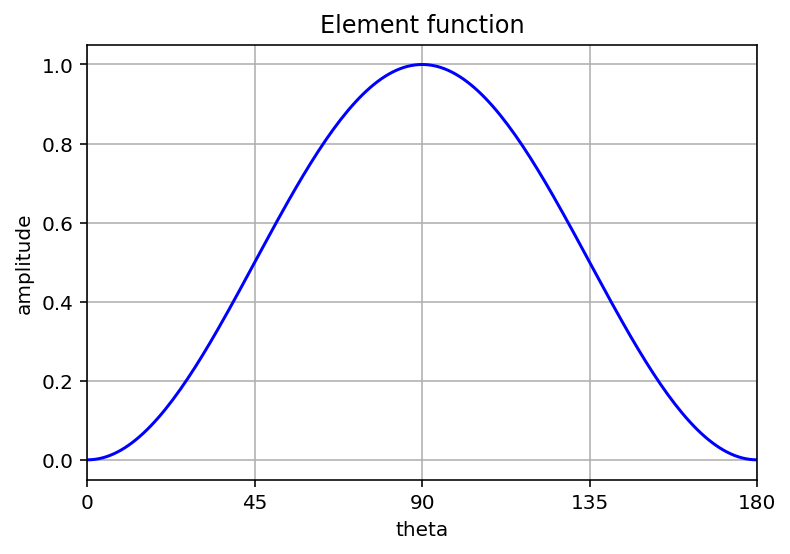

In [50]:
# plot function
theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#X_plt = X
#U_plt = 20*np.log10(U_theta) # convert to dB magnitude for plotting
#U_plt  = np.clip(U_plt,-100,np.inf) # set limits for plotted data

plt.plot(theta,X,'b')

plt.grid(True)
#plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude')
#plt.ylim(-60,20)
# set plot limits
#theta_min = -50
#theta_max = 50
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.title('Element function')
plt.show()

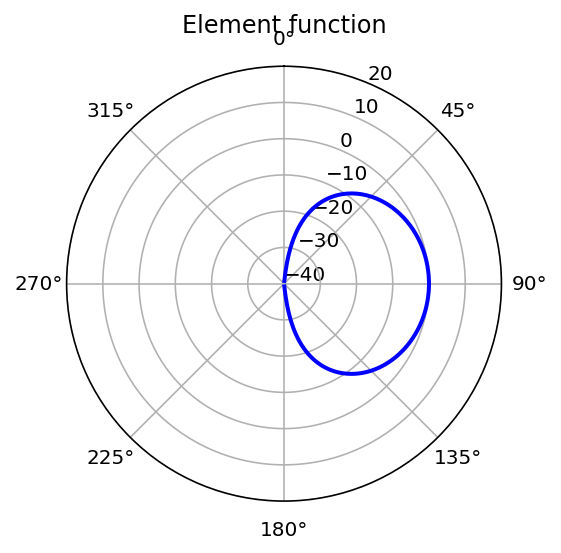

In [51]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
#theta_min = -90
#theta_max = 90
#step = 2
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
X_plt = 20*np.log10(X) # convert to dB magnitude for plotting
X_plt  = np.clip(X_plt,-100,np.inf) # set limits for plotted data
ax.plot(theta,X_plt,'b',linewidth = 2)

# Setting the graph title & legend
plt.title('Element function')
#plt.legend()
plt.show()

## Create intensity pattern
Create the intensity array from the element function.

In [52]:
# define the range for phi
step = 1  # step size
phi_min = 0
phi_max = 360
phi = np.arange(phi_min,phi_max,step)

# build full element pattern from function
U = (np.broadcast_to(X, (len(phi),len(X)))).T  # make radiation intensity array
print('array, number of rows = {:d}'.format(np.shape(U)[0]))
print('array, number of columns = {:d}'.format(np.shape(U)[1]))

array, number of rows = 181
array, number of columns = 360


## save to data file

In [53]:
# export element pattern as a complex array
pickle.dump(U.astype(dtype=complex), open( "EP.pkl", "wb" ))

## Contour plot
Change theta for plotting  

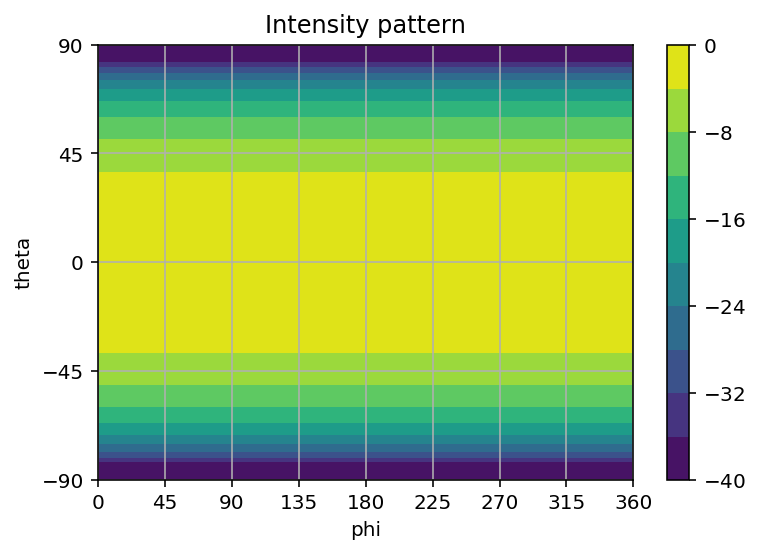

In [39]:
step = 1  # step size for various ranges
theta_min = -90
theta_max = 90
phi_min = 0
phi_max = 360

U_plt = 20*np.log10(np.abs(U)) # convert to dB magnitude for plotting
U_plt  = np.clip(U_plt,-40,np.inf) # set limits for plotted data

theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,U_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.title('Intensity pattern')
plt.show()

## principle plane cuts

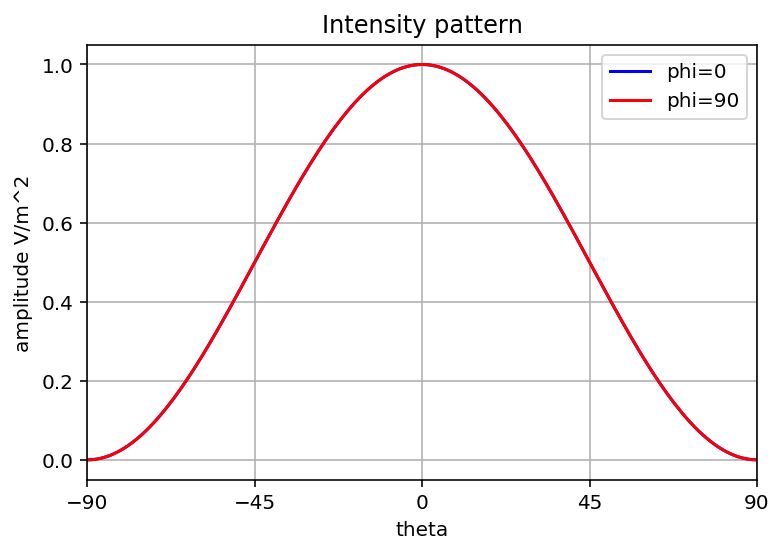

In [40]:
# plotting principle plane cuts
plt.plot(theta,U[:,0],'b',label='phi=0')
plt.plot(theta,U[:,int(90/step)],'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude V/m^2')
#plt.ylim(40,100)
# set plot limits
#theta_min = -50
#theta_max = 50
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.title('Intensity pattern')
plt.show()

## Polar plot

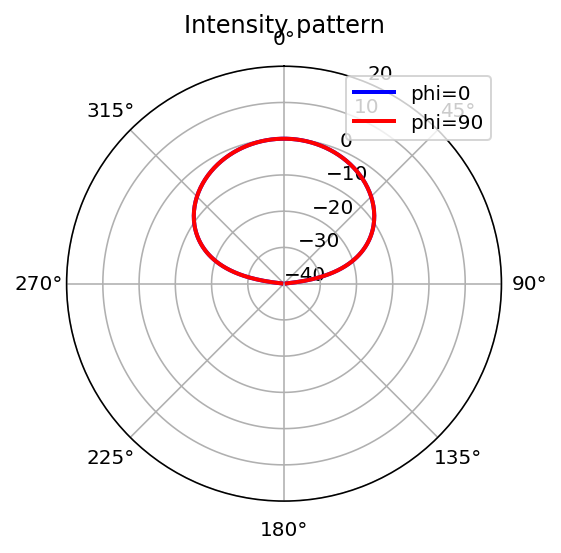

In [41]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta_min = -90
theta_max = 90
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(U[:,0])),'b',linewidth = 2,label='phi=0')
ax.plot(theta,20*np.log10(np.abs(U[:,int(90/step)])),'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
plt.title('Intensity pattern')
plt.legend()
plt.show()

# Total radiated power
The total radiated power can be found by integrating over all directions:  

$P_{tot}=\int _{0}^{{2\pi }}\int _{0}^{\pi}U(\theta ,\phi )\sin(\theta )\,d\theta \,d\phi$  

The units are assumed to be watts because units for U are $W/m^2$.  

In [42]:
# limits of integration
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[:,i])*np.sin(theta),theta)

# then an integral over the result
P_tot = np.trapz(I,phi)

print('total radiated power = {:.3f}'.format(P_tot))

total radiated power = 8.354


## Gain

In [43]:
U_max = U.max()
print('U_max = {:.3f}'.format(U_max))
print('U_max = {:.3f} dB'.format(10*np.log10(U_max)))
D = 4*np.pi*U_max/P_tot
print('directivity = {:.3f}'.format(D))

A_eff = 1  # antenna efficiency

G = A_eff*D
print('element gain = {:.3f}'.format(G))
print('element gain = {:.2f} dBi'.format(10*np.log10(G)))

U_max = 1.000
U_max = 0.000 dB
directivity = 1.504
element gain = 1.504
element gain = 1.77 dBi


In [44]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
phi = np.arange(phi_min,phi_max,step)

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
theta = theta*np.pi/180 # convert to radians

X = np.zeros(len(theta),dtype=float)

Bo = 3.7 # set peak value of the function
X = Bo*np.sin(theta)**20

# build full element pattern from function
U = (np.broadcast_to(X, (len(phi),len(X)))).T  # make radiation intensity array

# limits of integration
theta_min = 0
theta_max = 180
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[:,i])*np.sin(theta),theta)

# then an integral over the result
P_tot = np.trapz(I,phi)

print('total radiated power = {:.3f}'.format(P_tot))

U_max = U.max()
print('U_max = {:.3f}'.format(U_max))
print('U_max = {:.3f} dB'.format(10*np.log10(U_max)))
D = 4*np.pi*U_max/P_tot
print('directivity = {:.3f}'.format(D))

A_eff = 1  # antenna efficiency

G = A_eff*D
print('element gain = {:.3f}'.format(G))
print('element gain = {:.2f} dBi'.format(10*np.log10(G)))


total radiated power = 12.531
U_max = 3.700
U_max = 5.682 dB
directivity = 3.710
element gain = 3.710
element gain = 5.69 dBi


# Isotropic radiator
An isotropic radiator is a theoretical point source of electromagnetic or sound waves which radiates the same intensity of radiation in all directions. It has no preferred direction of radiation. It radiates uniformly in all directions over a sphere centred on the source. Isotropic radiators are used as reference radiators with which other sources are compared, for example in determining the gain of antennas. A coherent isotropic radiator of electromagnetic waves is theoretically impossible, but incoherent radiators can be built. An isotropic sound radiator is possible because sound is a longitudinal wave.  

## Create intensity pattern
Create the intensity array for an isotropic radiator.  All values = 1.

In [45]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
phi = np.arange(phi_min,phi_max,step)

U = np.ones((len(theta),len(phi)),dtype=float)/(4*np.pi)

print('array, number of rows = {:d}'.format(np.shape(U)[0]))
print('array, number of columns = {:d}'.format(np.shape(U)[1]))

array, number of rows = 181
array, number of columns = 360


In [47]:
# limits of integration
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna intensity pattern by sine(theta)
# integrate over every column
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(np.abs(U[:,i])*np.sin(theta),theta)

# then an integral over the result
P_tot = np.trapz(I,phi)

print('total radiated power = {:.6f}'.format(P_tot))

print('surface area of a sphere = {:f}'.format(4*np.pi))

total radiated power = 0.997197
surface area of a sphere = 12.566371


# plotting some other shaps
Some of shapes could be used to model back lobes of the element.  
- $sin(x)^n$:  this pattern has no back lobes, so when $\alpha$ is 90, there is no earth component in the pattern
- cardioid: $r = 1 − sin θ$
-super cardiod:  could combine the cardiod pattern with $sin(x)^n$ to get some back lobes

other functions:
- r = sin 44θ − 2 cos θ
- r = sin 4θ
- r = sin θ

# cardiod


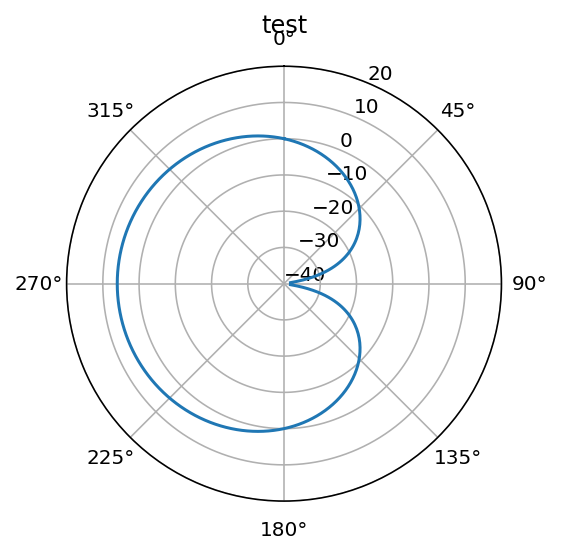

In [13]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

X = 1-np.sin(theta)
X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

# $r = sin 44\theta − 2 cos \theta$

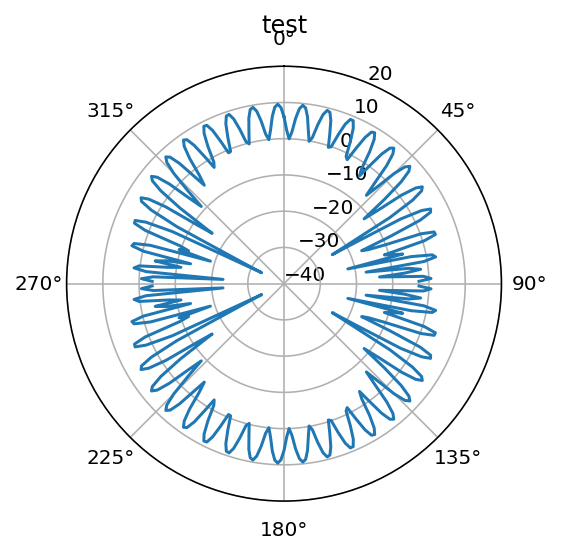

In [27]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

X = np.sin(44*theta)-2*np.cos(theta)
X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

# $r = sin 4 \theta$

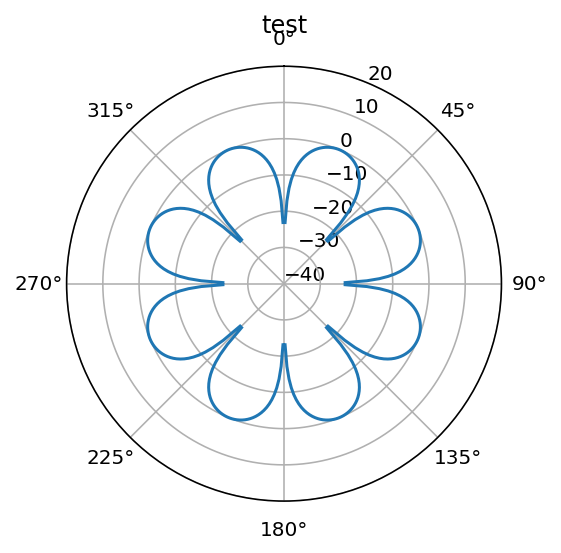

In [19]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

X = np.sin(4*theta)
X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

# $r = sin \theta$

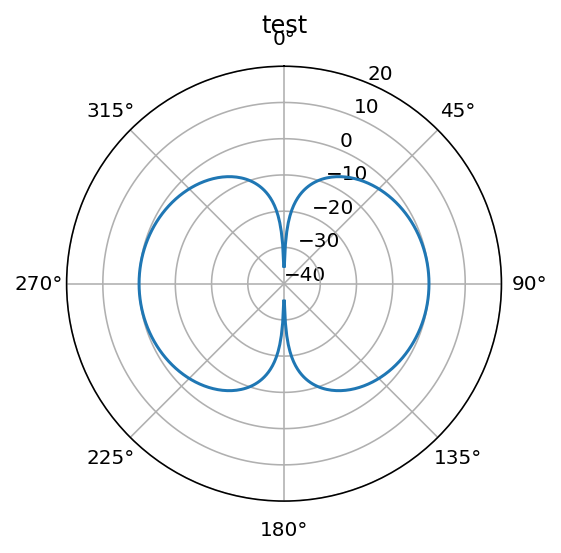

In [20]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

X = np.sin(theta)
X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

# $r = sin^n \theta$

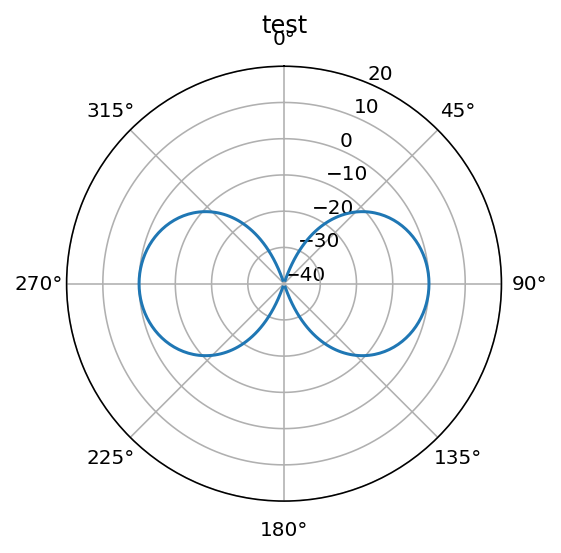

In [2]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

X = np.sin(theta)**4
X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()

# Combo
$r = sin \theta$ for 0 < theta < 180  
$r = $ for 180 < theta < 360  

$f(n) =
\begin{cases}
sin^2 \theta,  & \text{for 0 < $\theta$ < 180} \\
\frac {sin 4\theta}{20}, & \text{for 180 $\leq$ $\theta$ < 360}
\end{cases}$

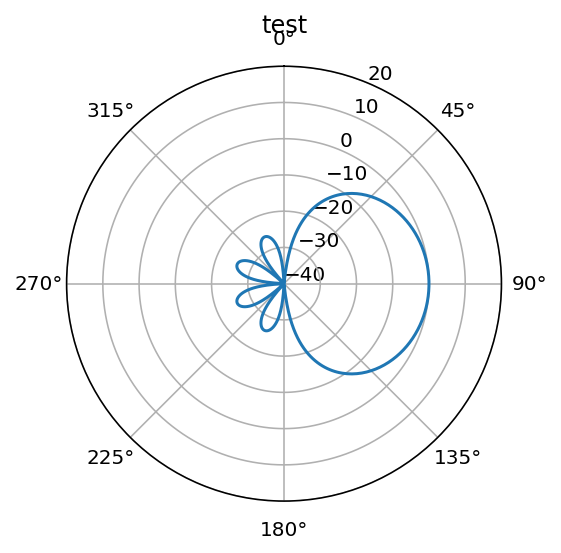

In [34]:
# define function over the following theta range
step = 1
theta_min = 0
theta_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
#theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevent divide by zero
#theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
#theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
X = np.zeros(len(theta),dtype=float)

# for 0 < theta < 180  
X[0:179] = np.sin(theta[0:179])**2

# for 180 < theta < 360  
X[180:-1] = np.sin(4*theta[180:-1])/20

X[np.where(X == 0)[0]] = 0.001 # remove zero value, prevent divide by zero

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 21
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180

# Polar plot
ax.plot(theta,20*np.log10(np.abs(X)))

# Setting the graph title & legend
plt.title('test')
#plt.legend()
plt.show()